In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [2]:
data = pd.read_csv('fifa.csv')
data.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Processamento de dados

In [3]:
#retirando colunas irrelavantes
data.drop(['Unnamed: 0','ID','Photo', 'Flag', 'Club Logo', 'Loaned From'], axis=1, inplace=True)
cols = [i for i in range(22,49)]
data.drop(data.columns[cols], axis = 1, inplace=True)

#arrumando a altura e o peso
pd.options.display.max_columns = 90
data['Weight'] =  data['Weight'].str[:3].astype(float) /  2.205
data['Height(cm)'] = data['Height'].str.split("'") 
data['Height'] = (12 * data['Height(cm)'].str[0].astype(float) + data['Height(cm)'].str[1].astype(float)) * 2.54
data.drop(['Height(cm)'], axis=1, inplace=True)
data.rename({'Height': 'Height (cm)', 'Weight': 'Weight (kg)'},axis=1, inplace=True)


In [4]:
#arrumando o valor, salário e cláusula de quebra
s = pd.Series(['Value','Wage','Release Clause'])
for i in s:
  data['aux1'] = data[i].str.extract('(€\d+)')
  data['aux1'] = data['aux1'].str.extract('(\d+)')
  data['aux1'] = data['aux1'].astype(float)
  data['aux2'] = data[i].str.extract('(\.\d+)')
  data['aux2'].fillna(0, inplace=True)
  data['aux2'] = data['aux2'].astype(float)
  data[i] = data['aux1'] + data['aux2']
  data.drop(['aux1', 'aux2'],axis=1,inplace=True)

In [5]:
#Arrumando os tipos corporais
data.loc[data['Body Type'] == 'Akinfenwa', 'Body Type'] = 'Stocky'
data.loc[data['Body Type'] == 'Neymar', 'Body Type'] = 'Lean'
data.loc[data['Body Type'] == 'Messi', 'Body Type'] = 'Lean'
data.loc[data['Body Type'] == 'C. Ronaldo', 'Body Type'] = 'Stocky'
data.loc[data['Body Type'] == 'Shaqiri', 'Body Type'] = 'Stocky'
data.loc[data['Body Type'] == 'Courtois', 'Body Type'] = 'Normal'
data.loc[data['Body Type'] == 'PLAYER_BODY_TYPE_25', 'Body Type'] = 'Normal'

#Agora só há três tipos
set(data['Body Type'])

{'Lean', 'Normal', 'Stocky', nan}

In [6]:
#tamanho normal
data.shape

(18207, 56)

In [7]:
#tamanho depois de remover os nulos (diferença de ~1500)
data = data.dropna()
data.shape

(16643, 56)

## Análise explatória de dados (Thales)

In [8]:
#A "cara" do dataset:
display(data.head())

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height (cm),Weight (kg),Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,Argentina,94,94,FC Barcelona,110.5,565.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Lean,Yes,RF,10.0,"Jul 1, 2004",2021,170.18,72.108844,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77.0,405.0,2228,Right,5.0,4.0,5.0,High/ Low,Stocky,Yes,ST,7.0,"Jul 10, 2018",2022,187.96,82.993197,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5,290.0,2143,Right,5.0,5.0,5.0,High/ Medium,Lean,Yes,LW,10.0,"Aug 3, 2017",2022,175.26,68.027211,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1
3,De Gea,27,Spain,91,93,Manchester United,72.0,260.0,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",2020,193.04,76.190476,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6
4,K. De Bruyne,27,Belgium,91,92,Manchester City,102.0,355.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",2023,180.34,69.841270,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4


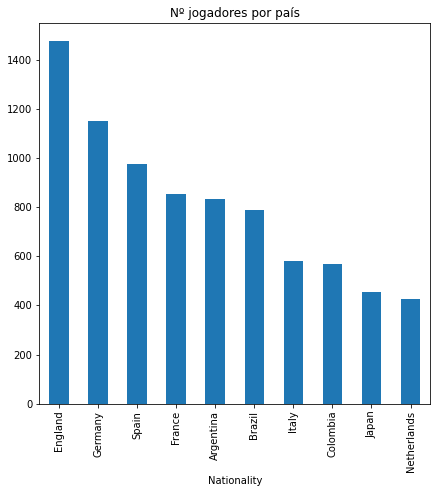

In [9]:
attribute = data.groupby(['Nationality'], as_index = False).count()
#attribute = attribute[['Nationality', 'Name']]
attribute = pd.DataFrame(attribute[['Nationality', 'Name']]).sort_values(by = 'Name', ascending = False)
attribute = attribute[:10]

#attribute['Name'].plot.bar(x = 'Nationality', xlabel = 'País', title = 'Salário médio por nacionalidade', ylabel = 'Valor (milhares de euros)', legend=False, figsize = (7,7))
attribute.plot.bar(x = 'Nationality', title = 'Nº jogadores por país', figsize = (7,7), legend = False)

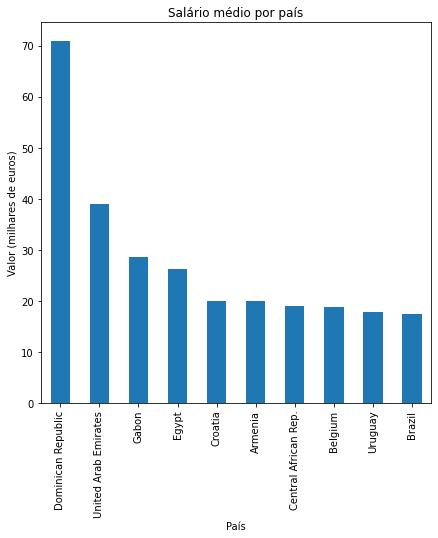

In [10]:
attribute = data.groupby(['Nationality'], as_index = False).mean()
attribute = pd.DataFrame(attribute[['Nationality', 'Wage']]).sort_values(by = 'Wage', ascending = False)
attribute = attribute[:10]

attribute.plot.bar(x = 'Nationality', xlabel = 'País', title = 'Salário médio por país', ylabel = 'Valor (milhares de euros)', legend=False, figsize = (7,7))

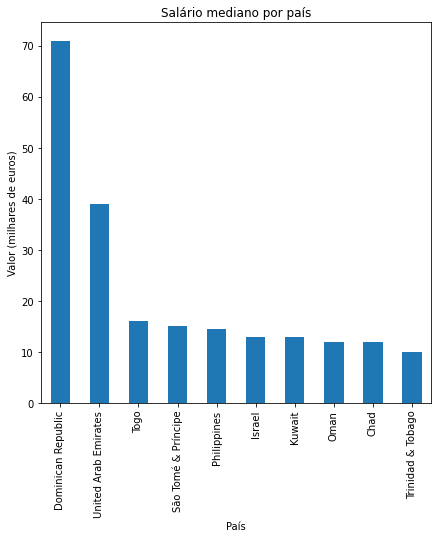

In [11]:
attribute = data.groupby(['Nationality'], as_index = False).median()
attribute = pd.DataFrame(attribute[['Nationality', 'Wage']]).sort_values(by = 'Wage', ascending = False)
attribute = attribute[:10]

attribute.plot.bar(x = 'Nationality', xlabel = 'País', title = 'Salário mediano por país', ylabel = 'Valor (milhares de euros)', legend=False, figsize = (7,7))

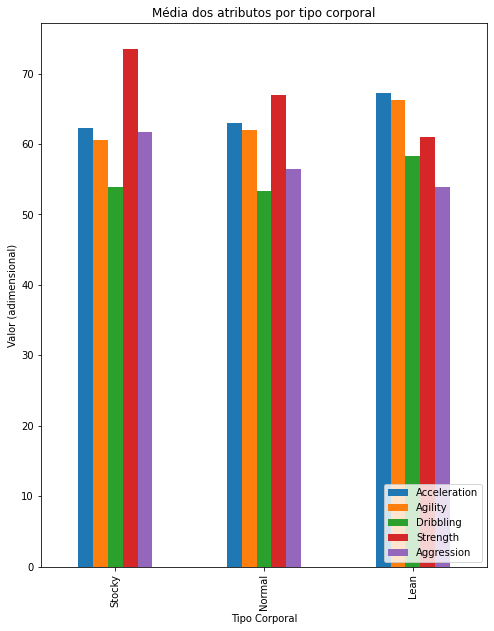

In [12]:
#Médias dos atributos por tipo corporal:
attribute = data.groupby(['Body Type'], as_index = False).mean()

#A maioria das categorias são iguais para todos os grupos, mas essas apresentam algumas diferenças:
attribute = pd.DataFrame(attribute[['Body Type', 'Acceleration', 'Agility', 'Dribbling', 'Strength','Aggression']]).sort_values(by = ['Acceleration', 'Agility', 'Dribbling', 'Strength','Aggression'])

#Percebe-se que os atletas magros são, em média, um pouco mais rápidos, agéis e driblam melhor.
#Os mesormorfos são mais pesados, fortes e agressivos

attribute.plot.bar(x ='Body Type', xlabel = 'Tipo Corporal', ylabel ='Valor (adimensional)', title='Média dos atributos por tipo corporal', figsize = (8,10))
plt.legend(loc = 4, prop = {'size': 10})

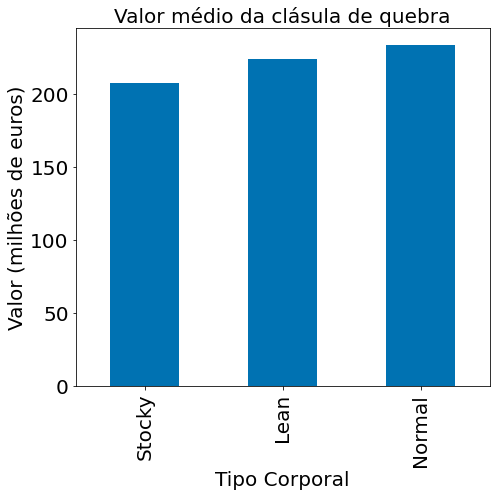

In [47]:
attribute = data.groupby(['Body Type'], as_index = False).mean()
attribute = pd.DataFrame(attribute[['Body Type', 'Release Clause']]).sort_values(by = 'Release Clause')
attribute.plot.bar(x = 'Body Type', xlabel = 'Tipo Corporal', title = 'Valor médio da clásula de quebra', ylabel = 'Valor (milhões de euros)', legend=False, figsize = (7,7))

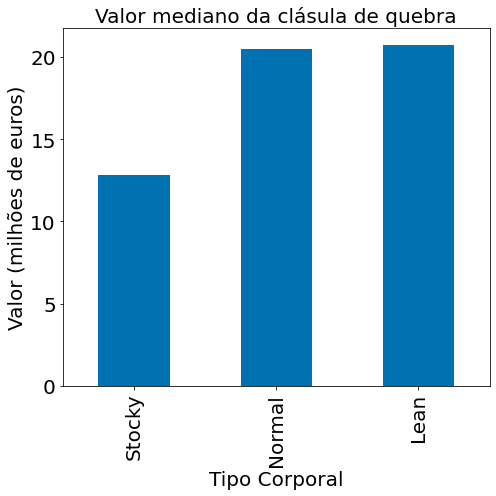

In [48]:
#Vamos considerar as medianas dos mesmos atributos
attribute_median = data.groupby(['Body Type'], as_index = False).median()
attribute_median = pd.DataFrame(attribute_median[['Body Type', 'Release Clause']]).sort_values(by = 'Release Clause')
attribute_median.plot.bar(x = 'Body Type', xlabel = 'Tipo Corporal', title = 'Valor mediano da clásula de quebra', ylabel = 'Valor (milhões de euros)', legend=False, figsize = (7,7))

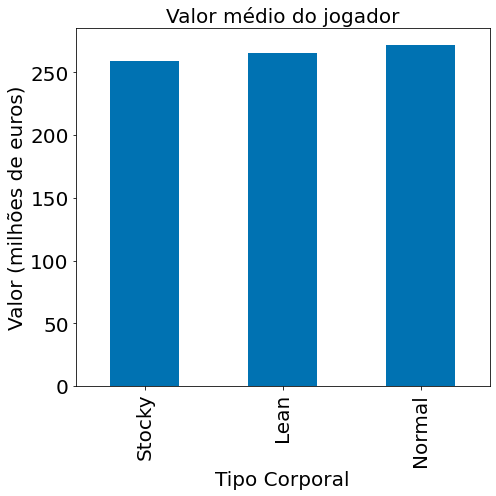

In [49]:
attribute_median = data.groupby(['Body Type'], as_index = False).mean()
attribute_median = pd.DataFrame(attribute_median[['Body Type', 'Value']]).sort_values(by = 'Value')
attribute_median.plot.bar(x = 'Body Type', xlabel = 'Tipo Corporal', title = 'Valor médio do jogador', ylabel = 'Valor (milhões de euros)', legend=False, figsize = (7,7))

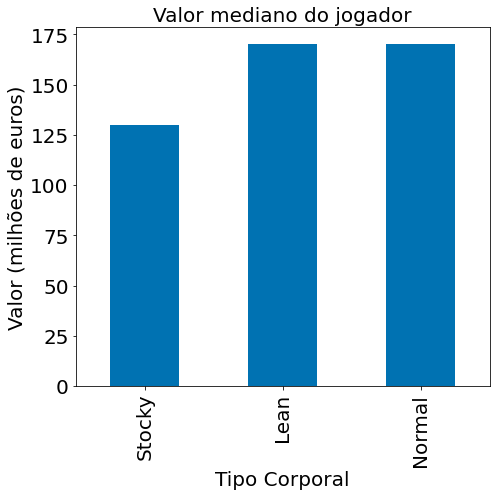

In [50]:
attribute_median = data.groupby(['Body Type'], as_index = False).median()
attribute_median = pd.DataFrame(attribute_median[['Body Type', 'Value']]).sort_values(by = 'Value')
attribute_median.plot.bar(x = 'Body Type', xlabel = 'Tipo Corporal', title = 'Valor mediano do jogador', ylabel = 'Valor (milhões de euros)', legend=False, figsize = (7,7))

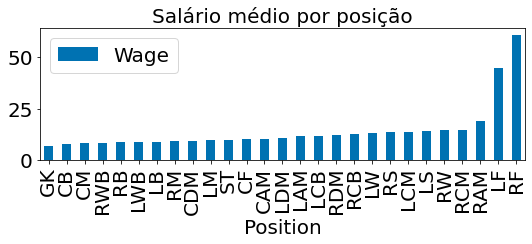

In [51]:
attribute_position = pd.DataFrame(data.groupby(['Position']).mean()['Wage'])
attribute_position = attribute_position.sort_values(by = 'Wage')
attribute_position.plot.bar(title = "Salário médio por posição")

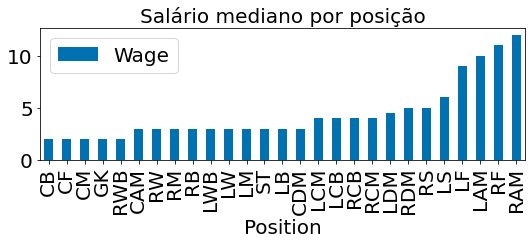

In [52]:
attribute_position = pd.DataFrame(data.groupby(['Position']).median()['Wage'])
attribute_position = attribute_position.sort_values(by = 'Wage')
attribute_position.plot.bar(title = "Salário mediano por posição")

O ponto principal é que a visualização dos dados pode mudar muito dependendo da estatística sendo analisada. Isto é, diferenças que existem na média podem não existir quando consideramos a mediana (e vice-versa).

In [19]:
#Será que a chance pode explicar essa diferença?
#No mundo aleatório, a distribuição de salários seria independente
#da posição do jogador
#Façamos um teste de permutação

# df = data[['Wage','Position']].copy()

# filter = ((df['Position'] == 'RF'))
# print('Média das outras posições : ', round(df[~filter]['Wage'].mean(), 2))
# print('Média das posições RF/LF: ', round(df[filter]['Wage'].mean(), 2))
# print('A diferença: ', round(df[filter]['Wage'].mean(), 2) - round(df[~filter]['Wage'].mean(), 2))

# n = 5000
# values = np.zeros(n)

# for i in range(n):
#   #np.random.seed(i)
#   #np.random.shuffle(filter.values)
#   sample = df.sample(len(df), replace = True)
#   values[i] = sample[filter]['Wage'].median()

# plt.hist(values, bins = 50)


In [20]:
# print(dif)
# total = len(dif)
# sum_greater = 0

# for i in dif:
#   if i >= 40:
#     sum_greater += 1

# sum_greater


In [21]:
#Porém, vamos analisar os dados para a mediana:
# attribute_position = pd.DataFrame(data.groupby(['Position']).median()['Wage'])
# attribute_position = attribute_position.sort_values(by = 'Wage')
# attribute_position.plot.bar()



Os resultados para a mediana são bem menos impressionantes. A diferença aqui é de apenas 7K, enquanto que para a média, era de 42k, seis vezes mais. Como interpretar isso? Muito provavelmente, existem jogadores em RF/LF que estão puxando a média para cima. Na prática, essas posições não são necessariamente as melhores do ponto de vista financeiro.

## Hipótese I (Leandro)



In [22]:
data.loc[data['Position'] == "GK"].sort_values("Height (cm)", ascending=False)
data.sort_values("Height (cm)", ascending=False)

data.head(10)

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height (cm),Weight (kg),Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,Argentina,94,94,FC Barcelona,110.5,565.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Lean,Yes,RF,10.0,"Jul 1, 2004",2021,170.18,72.108844,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77.0,405.0,2228,Right,5.0,4.0,5.0,High/ Low,Stocky,Yes,ST,7.0,"Jul 10, 2018",2022,187.96,82.993197,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5,290.0,2143,Right,5.0,5.0,5.0,High/ Medium,Lean,Yes,LW,10.0,"Aug 3, 2017",2022,175.26,68.027211,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1
3,De Gea,27,Spain,91,93,Manchester United,72.0,260.0,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",2020,193.04,76.190476,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6
4,K. De Bruyne,27,Belgium,91,92,Manchester City,102.0,355.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",2023,180.34,69.841270,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4
5,E. Hazard,27,Belgium,91,91,Chelsea,93.0,340.0,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,Yes,LF,10.0,"Jul 1, 2012",2020,172.72,73.922902,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172.1
6,L. Modrić,32,Croatia,91,91,Real Madrid,67.0,420.0,2280,Right,4.0,4.0,4.0,High/ High,Lean,Yes,RCM,10.0,"Aug 1, 2012",2020,172.72,66.213152,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,137.4
7,L. Suárez,31,Uruguay,91,91,FC Barcelona,80.0,455.0,2346,Right,5.0,4.0,3.0,High/ Medium,Normal,Yes,RS,9.0,"Jul 11, 2014",2021,182.88,86.167800,93.0,77.0,82.0,88.0,87.0,86.0,84.0,64.0,90.0,86.0,75.0,82.0,92.0,83.0,86.0,69.0,90.0,83.0,85.0,87.0,41.0,92.0,84.0,85.0,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,164.0
8,Sergio Ramos,32,Spain,91,91,Real Madrid,51.0,380.0,2201,Right,4.0,3.0,3.0,High/ Medium,Normal,Yes,RCB,15.0,"Aug 1, 2005",2020,182.88,82.086168,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0,104.6
9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,68.0,94.0,1331,Right,3.0,3.0,1.0,Medium/ Medium,Normal,Yes,GK,1.0,"Jul 16, 2014",2021,187.96,87.074830,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,144.5


**Hipótese**

Se um jogador brasileiro ganha mais que um jogador argentino e se isso é isso é provado aleatoriamente ou por um outro motivo alem de "u"

*uSerBrasileiro != uSerArgentino*


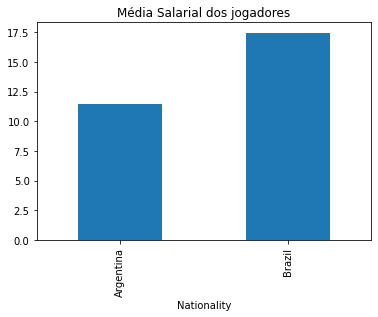

In [23]:
#data = pd.read_csv('fifa.csv', index_col='ID')
brasilArgentina = data.loc[(data['Nationality'] == 'Brazil') | (data['Nationality'] == 'Argentina')].sort_values('Wage', ascending = False)
brasilArgentina['log_wage'] = np.log(brasilArgentina['Wage'])

meanPlot = brasilArgentina[['Nationality','Wage']].groupby("Nationality").agg([np.mean])
meanPlot.plot(kind = "bar", y = "Wage", legend = False,
            title = "Média Salarial dos jogadores")

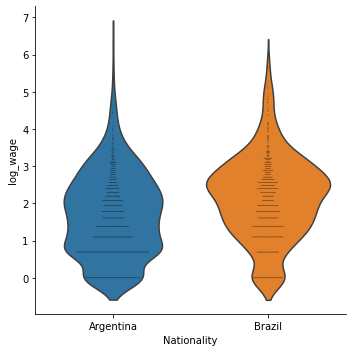

In [24]:
g = sns.catplot(x="Nationality", y="log_wage", kind="violin", inner=None, data=brasilArgentina)
sns.swarmplot(x="Nationality", y="log_wage", color="k", size=0.5, data=brasilArgentina, ax=g.ax)

Pelo violin plot é possível perceber que existem menos jogadores brasileiro que recebem "pouco" comparado aos jogadores argentinos, onde no centro do "violiono" brasileiro é possivel reparar que ele é mais "aberto", representando uma quantidade maior de jogadores com salario "médio".

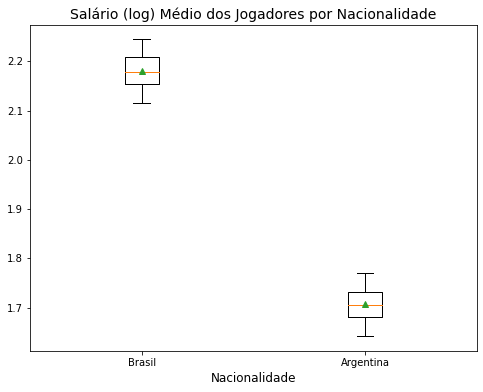

In [25]:
def bootstrap_mean(df1, df2, column, n=1000):
    size1 = len(df1)
    size2 = len(df2)
    values1 = np.zeros(n)
    values2 = np.zeros(n)
    values_diff = np.zeros(n)
    for i in range(n):
        sample1 = df1[column].sample(size1, replace=True, random_state=i)
        sample2 = df2[column].sample(size2, replace=True, random_state=i*3)
        values1[i] = sample1.mean()
        values2[i] = sample2.mean()
        values_diff[i] = sample1.mean() - sample2.mean()
    return values1, values2, values_diff

brasil = brasilArgentina[brasilArgentina['Nationality']=='Brazil']
argentina = brasilArgentina[brasilArgentina['Nationality']=='Argentina']
col = 'log_wage'
v_brasil, v_argentina, v_diff = bootstrap_mean(brasil, argentina, col)

bp_data = [v_brasil, v_argentina]
plt.rcParams['figure.figsize']  = (8, 6)
plt.boxplot(bp_data, whis=[5, 95], positions=[1,2], showfliers=False, showmeans=True)
plt.xticks([1,2], ['Brasil', 'Argentina'], fontsize=10)
plt.ylabel('', fontsize=13)
plt.xlabel('Nacionalidade', fontsize=12)
plt.title('Salário (log) Médio dos Jogadores por Nacionalidade', fontsize=14)
plt.show()

**Teste A/B**

Realizando um teste *A/B* sobre os salários (em *log*) dos jogadores, percebemos que com 5% de chance os jogadores brasileiros se encontram com o mesmo salário que os argentinos, provando que com os dados usados no FIFA nesse ano, os brasileiros ganham mais que os argentinos

# Regressão (Rodrigo)


In [26]:
cols = ['Age', 'Wage']
series = data[cols].groupby('Age', as_index=False).mean()
series

,Age,Wage
0,16,1.170732
1,17,2.147887
2,18,2.134094
3,19,2.413607
4,20,4.111824
5,21,5.631967
6,22,7.533964
7,23,8.124474
8,24,9.577114
9,25,11.310201


In [27]:
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

ols = ['Age', 'Wage']

series = data[cols].groupby('Age', as_index=False).mean()
series

,Age,Wage
0,16,1.170732
1,17,2.147887
2,18,2.134094
3,19,2.413607
4,20,4.111824
5,21,5.631967
6,22,7.533964
7,23,8.124474
8,24,9.577114
9,25,11.310201


In [28]:
def beta(series, mean_x, mean_y):
    num = 0
    den = 0
    for i in range(len(series)):
        num += (series.iloc[i][0] - mean_x) * (series.iloc[i][1] - mean_y)
        den += (series.iloc[i][0] - mean_x) ** 2
    return num/den

mean_x = np.mean(series['Age'])
mean_y = np.mean(series['Wage'])
beta = beta(series, mean_x, mean_y)
beta

0.07967790390876903

In [29]:
alpha = mean_y - beta*mean_x
alpha

5.836746057155837

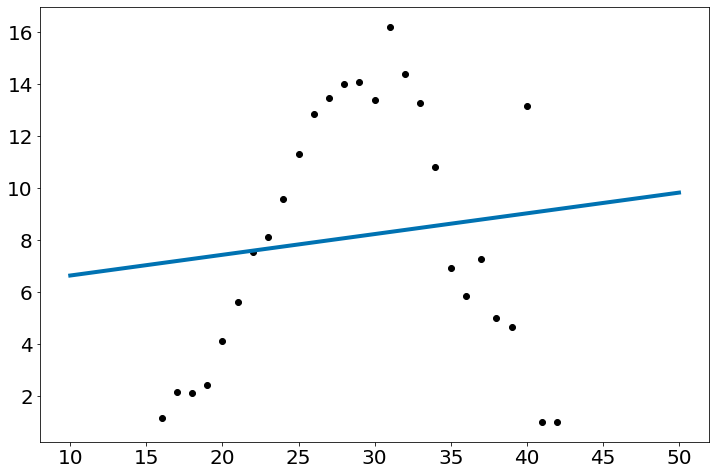

In [30]:
fig,ax = plt.subplots()
x = np.linspace(10.,50.)
ax.plot(x,beta*x+alpha)
x = np.array(series.iloc[:len(series)-1,0].values).reshape((-1,1)) 
y = np.array(series.iloc[:len(series)-1,1].values).reshape((-1,1))
plt.scatter(x,y,color="black")
plt.show()

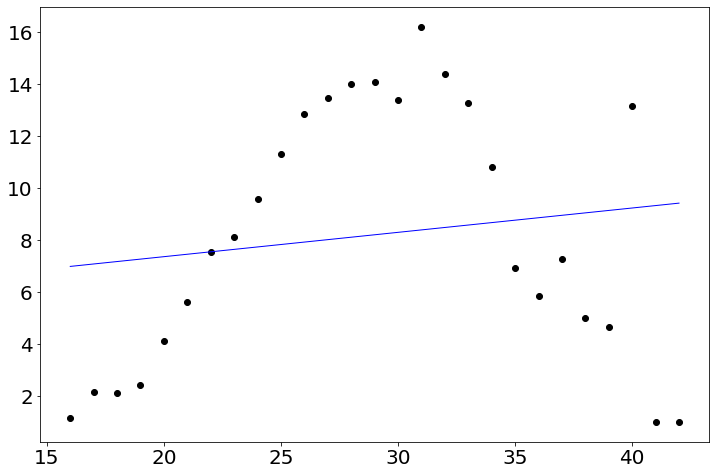

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
x = np.array(series.iloc[:len(series)-1,0].values).reshape((-1,1)) 
y = np.array(series.iloc[:len(series)-1,1].values).reshape((-1,1))

model.fit(x,y)
new_y = model.predict(x)
plt.scatter(x,y,color="black")
plt.plot(x,new_y,color="blue", linewidth=1)

In [32]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(x)

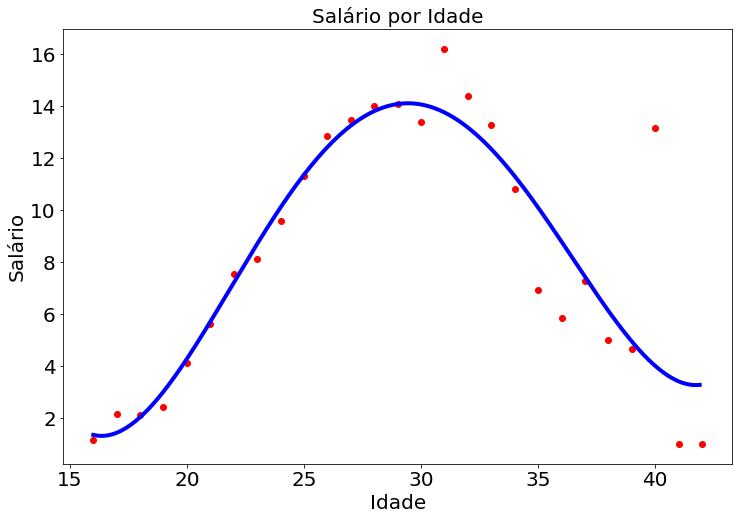

In [33]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
  
X_grid = np.arange(min(x),max(x),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='red') 
  
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 
  
plt.title("Salário por Idade")
plt.xlabel('Idade')
plt.ylabel('Salário')
plt.show()

# Outras Regressões (Hélio)

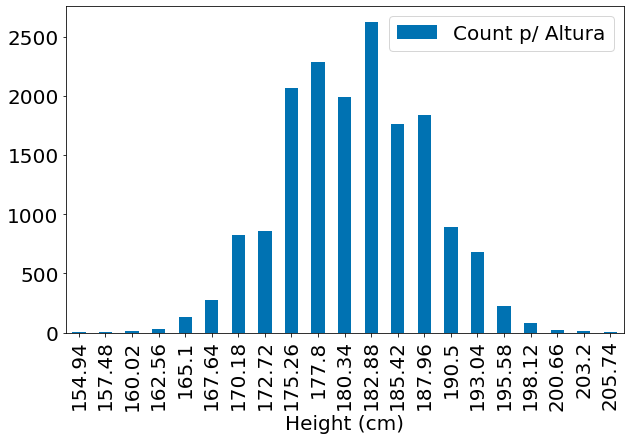

In [34]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data.reset_index(drop=True, inplace=True)
s = data[['Height (cm)']].round(2)
s['Count p/ Altura'] = s.groupby('Height (cm)')['Height (cm)'].transform('count')
s = s.sort_values(['Height (cm)'])
j = s.drop_duplicates(subset = ["Height (cm)","Count p/ Altura"])
j.reset_index(inplace=True, drop=True)
j.plot.bar(x='Height (cm)',y='Count p/ Altura',figsize=(10,6))

In [35]:
def error(alpha, beta, x, y):
    return y - alpha - beta*x

def sum_of_squared_errors(alpha, beta, x, y):
    result = 0
    index = 0
    while index < len(y):
      result += (error(alpha,beta,x[index],y[index]))**2
      index += 1
    result = result

    return result

def total_sum_of_squares(y):
    result = 0
    mean = y.mean()

    for element in y:
      result += (element - mean)**2
    result 

    return result

def r_squared(alpha, beta, x, y):
    SQT = total_sum_of_squares(y)
    SQR = sum_of_squared_errors(alpha,beta,x,y)

    return (SQT - SQR)/SQT

In [36]:
def linear_regression(x,y):
  alpha = 0
  beta = 0
  mean_x = x.mean()
  mean_y = y.mean()

  index = 0
  covariancia = 0
  variancia = 0
  while index < len(y):
    covariancia += (x[index] - mean_x)*(y[index] - mean_y)
    index += 1
  covariancia = covariancia/len(y)
  index = 0
  while index < len(x):
    variancia += (x[index] - mean_x)**2
    index += 1
  variancia = variancia/len(x)
  beta = covariancia/variancia
  alpha = mean_y - beta*mean_x

  return (alpha, beta)

In [37]:
def correlacao(x_name,y_name):
  x = data[x_name]
  y = data[y_name]
  x = x[:10000]
  y = y[:10000]
  print("jj")
  (alpha,beta) = linear_regression(x,y)
  print("Alpha , Beta:")
  print((alpha,beta))
  print("Coeficiente de Determinação:")
  print(r_squared(alpha,beta,x,y))
  plt.plot(data[x_name], data[y_name],'o')
  plt.plot(data[x_name], alpha + beta*data[x_name], color='r')

jj
Alpha , Beta:
(296.83115396815515, -1.2708291902794784)
Coeficiente de Determinação:
0.3408798391890583


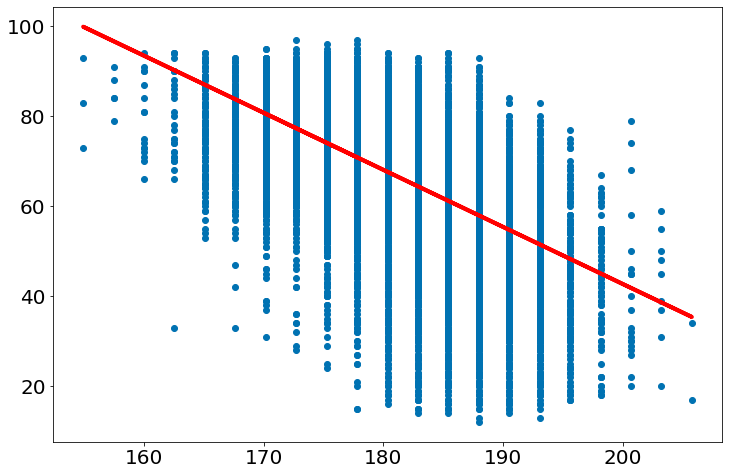

In [38]:
correlacao('Height (cm)','Acceleration')

jj
Alpha , Beta:
(318.7216731307507, -1.428002326730643)
Coeficiente de Determinação:
0.27354154486957394


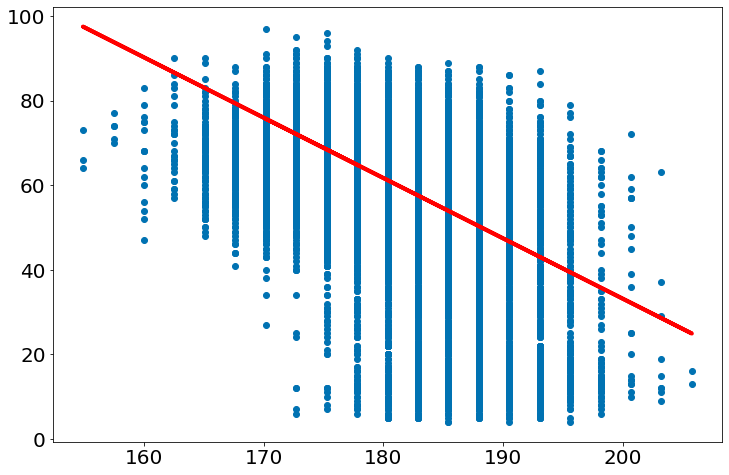

In [39]:
correlacao('Height (cm)','Dribbling')

jj
Alpha , Beta:
(77.39466589150689, -0.14413559332339526)
Coeficiente de Determinação:
0.002283332901360373


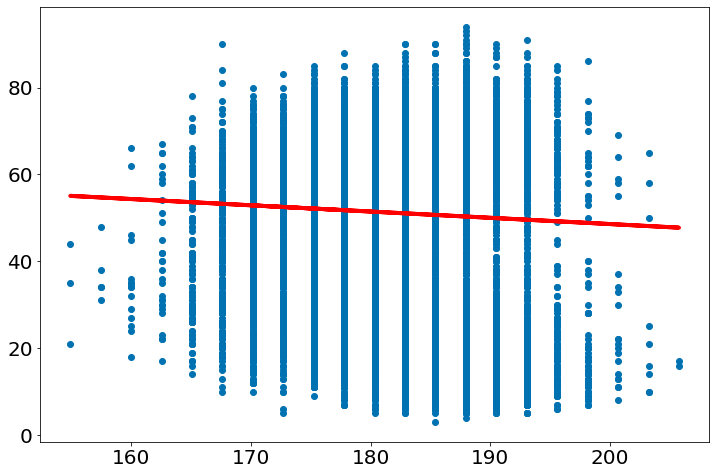

In [40]:
correlacao('Height (cm)','Marking')

jj
Alpha , Beta:
(373.9709042877697, -1.7043713484939258)
Coeficiente de Determinação:
0.6560665015920342


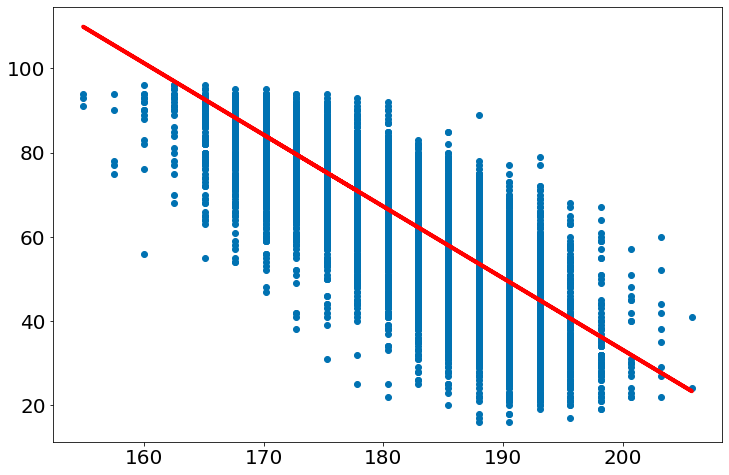

In [41]:
correlacao('Height (cm)','Balance')

jj
Alpha , Beta:
(70.84197200402228, -0.10668268383377727)
Coeficiente de Determinação:
0.0011842838988720353


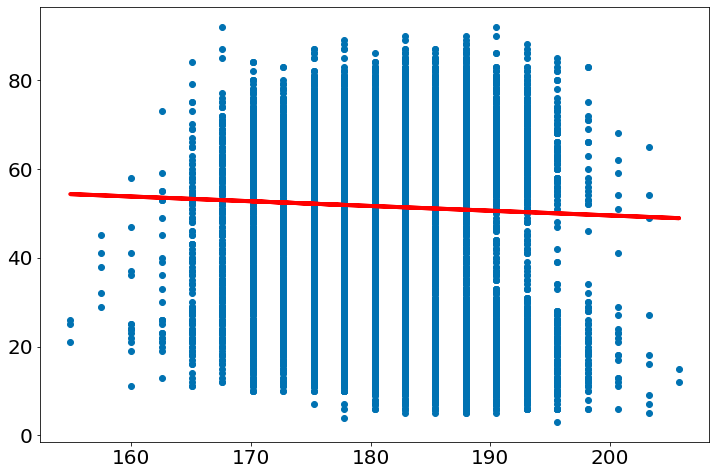

In [42]:
correlacao('Height (cm)','Interceptions')

jj
Alpha , Beta:
(-114.98543951428381, 1.0115224142027164)
Coeficiente de Determinação:
0.34330400570199


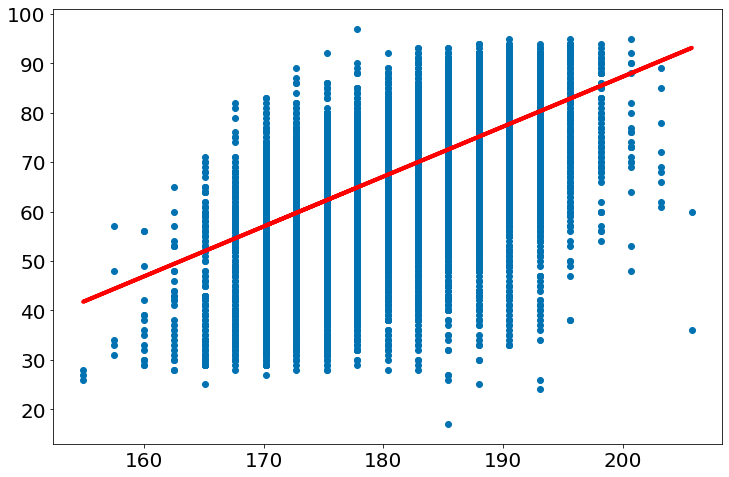

In [43]:
correlacao('Height (cm)','Strength')

jj
Alpha , Beta:
(-114.98543951428381, 1.0115224142027164)
Coeficiente de Determinação:
0.34330400570199


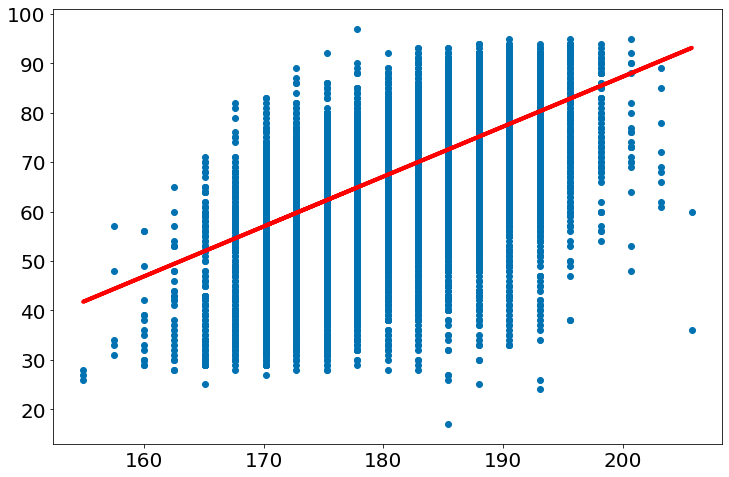

In [44]:
correlacao('Height (cm)','Strength')

Alpha , Beta:
(183.70490915844164, -0.6373693310124547)
Coeficiente de Determinação:
0.06894308299420678


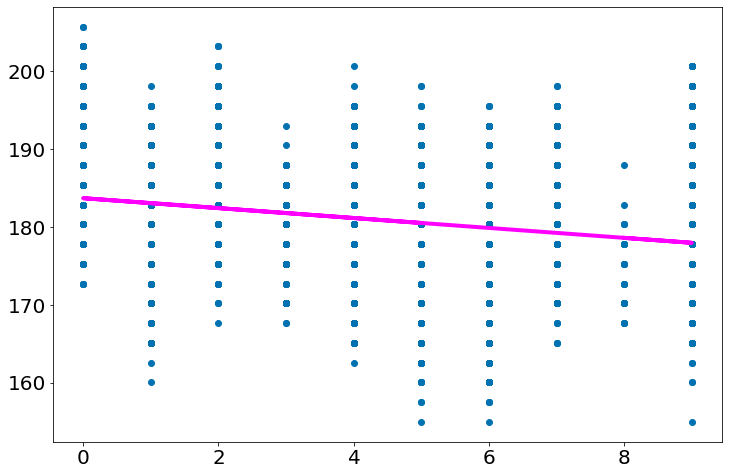

In [45]:
df = data[['Position','Height (cm)']]
df = df.dropna()

def set_values(row, value):
    return value[row]

map_dictionary ={"ST": 9, "CF": 9,
                 "RF" : 8, "LF": 8,
                 "LS" : 7, "RS" : 7,
                 "CAM": 6, "RAM" : 6, "LAM" : 6, "LW" : 6,"RW" : 6,
                 "RCM" : 5, "LCM" : 5, "RM" : 5,"LM" : 5,"CM" : 5,
                 "LDM" : 4, "CDM" : 4, "RDM" : 4,
                 "RWB" : 3, "LWB" : 3,
                 "RCB": 2, "CB": 2, "LCB": 2,
                 "LB": 1, "RB": 1,
                 "GK": 0} 

df['Position_Num'] = df['Position'].apply(set_values, args =(map_dictionary, )) 



df = df.reset_index()
y = df['Height (cm)']
x = df['Position_Num']

(alpha,beta) = linear_regression(x,y)
print("Alpha , Beta:")
print((alpha,beta))
plt.plot(df['Position_Num'], df['Height (cm)'],'o')
plt.plot(df['Position_Num'], alpha + beta*df['Position_Num'], color='magenta')
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
print("Coeficiente de Determinação:")
print(r_squared(alpha,beta,x,y))

## Template de Regressão

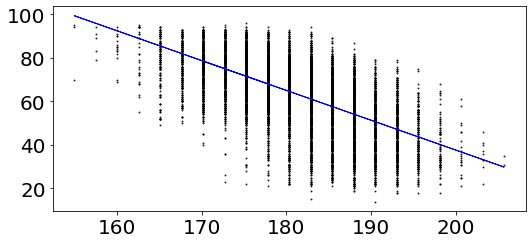

In [46]:
#modelo de regressão

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

#cria-se um modelo
model = LinearRegression()

#é só mudar os valores de x e y com as colunas que vocês quiserem
x = np.array(data['Height (cm)'].values).reshape((-1,1))
y = np.array(data['Agility'].values).reshape((-1,1))

model.fit(x,y)
new_y = model.predict(x)

#resultado
#parece que a altura e a agilidade estão inversamente correlacionados
plt.scatter(x, y, color="black", s=1, edgecolor='k', alpha=0.75)
plt.plot(x, new_y,color="blue", linewidth=1)

# A fazer:

* Mais regressões e hipóteses
* Arrumar os gráficos
* Intervalos de confiança e p-valor
* Entrega por streamlit
* Algo mais?


